# Nonlinear Least Squares
This notebook discusses and explains how to use the nonlinear least squares function, `NLLS`, and the nonlinear least squares class, `NllsClass`, available from the TFC utilities. They are used regularly in the context of TFC when minimizing the residual of differential equations, but are written in a general way so that they can be applied to any problem that requires nonlinear least-squares.

The `NLLS` function and `NllsClass` can utilize automatic differentiation, so the user need only supply the residual function. Moreover, both are designed to work with unkowns given as an array, a `TFCDict`, or a `TFCRobustDict`; the latter two options in particular are extremely useful when one has multiple array so unkowns such as in systems of ODEs or PDEs. Moreover, both `NLLS` and `NllsClass` JIT the entire nonlinear least-squares process, and provide the option to calculate the run-time of the compiled code. 

## `NLLS` Function
The NLLS function is designed for cases where the nonlinear least-squares needs to be run only once. 

### Positional input arguments
This function function takes in two required positional arguments and one optional position argument. The two required positional arguments are the initial guess for the unknowns and the residual function: the residual function must be structured such that the unkowns are the first argument. The one optional position argument is \*args, which is used if the residual function has more arguments than the unknowns. In other words, the residual function should be of the form, $\mathbb{L}(\xi,*args)$, where $\mathbb{L}$ is the residual function, $\xi$ are the unknowns, and \*args are any additional arguments.

### Optional input keyword arguments
The optional keyword arguments to the `NLLS` function are:

* $\mathcal{J}$ - User-specified Jacobian. The default option is to compute the Jacobian of $\mathbb{L}$ with respect to $\xi$ using the automatic differentiation 
* tol - Tolerance used in [termination criteria](#Termination-criteria). Default is $1\times10^{-13}$.
* maxIter - Maximum number of nonlinear least-squares iterations. Default is 50.
* User specified condition function. Default is None, which results in a condition that checks the three conditions listed in [termination criteria](#Termination-criteria).
* body - User specified body function. Default is None, which results in a body function that performs least-squares using the method provided and updates $\xi$, $\Delta \xi$ and $it$, the current number of iterations.
* timer - Setting this to True will time the nonlinear least squares using the timer specified by timerTypep. Note that doing so adds a slight increase in run time, as one iteration of the nonlinear least squares is run first to avoid timing the JAX trace. The default is False.
* timerType - The timer from the timer package that will be used to time the code. The default is [process_time](https://docs.python.org/3/library/time.html).
* printOut" - Currently this option is not implemented. If JAX allows printing in JIT-ed functions in the future, then it will display the value of $\max(|\mathbb{L}|)$ at each iteration.
* method - Method used to invert the matrix at each iteration. The default is pinv. The two options are:
  * pinv - Uses [Numpy's pinv](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html) to perform the inversion.
  * lstsq - Uses [Numpy's lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html) to perform the inversion.

### Outputs
The outputs of the function are:

* $\xi$ - The value of $\xi$ at the end of the nonlinear least squares.
* $it$ - The number of iterations.
* time - If the keyword argument timer = True, then the third output is the time the nonlinear least-squares took; otherwise, there is no third output.

### Termination criteria
The `NLLS` function stops iterating when any of the following criteria are true:

* $\max(|\mathbb{L}|) < \verb"tol"$
* $\max(|\Delta \xi|) < \verb"tol"$
* Number of iterations > `maxIter`

As a demonstrative example, suppose one wanted to approximate the function $y = a e^{b x}$ using a linear expansion of Chebyshev polynomials, where the coefficients in that expansion are nonlinear combinations of a paramter $\xi$. 

NLLS run time: 0.0034787989999998103 seconds.
Maximum error: 5.551115123125783e-16


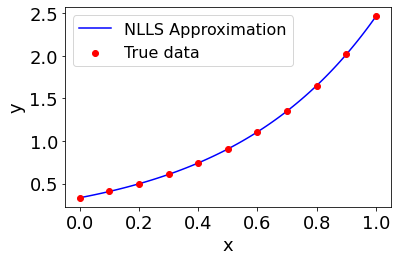

In [1]:
import jax.numpy as np
from tfc.utils import BF, NLLS, MakePlot

# This line is added for Python notebooks but is not necessary in a regular Python script.
%matplotlib inline 

# Create the true data
a = 1/3
b = 2
x = np.linspace(0,1,101)
y = a*np.exp(b*x)

# Create the Chebyshev polynomials
cp = BF.CP(0.,1.,np.array([-1],dtype=np.int32),20)
H = cp.H(x,0,True)

# Create the approximating function
g = lambda xi: np.dot(H,xi**2-xi)

# Create the residual function
res = lambda xi: g(xi)-y

# Solve for the unknowns using NLLS
xi0 = np.zeros(H.shape[1])
xi,it,time = NLLS(xi0,res,timer=True)

# Plot and print results
p = MakePlot('x','y')
p.ax[0].scatter(x[::10],y[::10],color='r',label='True data',zorder=3)
p.ax[0].plot(x,g(xi),'b-',label='NLLS Approximation')
p.ax[0].legend()
p.show()

print("NLLS run time: "+str(time)+" seconds.")
print("Maximum error: "+str(np.max(np.abs(res(xi)))))

As one can see, parameters $\xi$ were found in a matter of milliseconds that reduce the maximum residual value to nearly machine level precision. As mentioned earlier, this can be done not just for arrays of unkowns, but `TFCDict`s and `TFCRobustDicts` as well. In addition, the loss functions can take extra arguments other than the unknown parameters. For example, suppose we have a dictionary of unknowns used in our approximating function $g$, and that $g$ also takes in some other arguments.

NLLS run time: 0.004010904000000259 seconds.
Maximum error: 4.440892098500626e-16


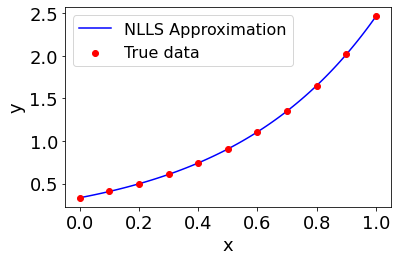

In [2]:
from tfc.utils import TFCDict

# Create the approximating function
g = lambda xi,c1,c2: c1*np.dot(H,xi['xi1']*xi['xi2']-xi['xi2'])+c2

# Create the residual function
c1 = 2.
c2 = 1.
res = lambda xi,c1,c2: g(xi,c1,c2)-y

# Solve for the unknowns using NLLS
xi = TFCDict({'xi1':np.zeros(H.shape[1]),
              'xi2':np.zeros(H.shape[1])})
xi,it,time = NLLS(xi,res,c1,c2,timer=True,tol=1e-15)

# Plot and print results
p = MakePlot('x','y')
p.ax[0].scatter(x[::10],y[::10],color='r',label='True data',zorder=3)
p.ax[0].plot(x,g(xi,c1,c2),'b-',label='NLLS Approximation')
p.ax[0].legend()
p.show()

print("NLLS run time: "+str(time)+" seconds.")
print("Maximum error: "+str(np.max(np.abs(res(xi,c1,c2)))))

Once again, $\xi$ parameters were found in a matter of milliseconds that reduce the maximum residual value to nearly machine level precision. 

## Nonlinear least squares class (`NllsClass`)
The `NllsClass` is designed to be used when the nonlinear least-squares must be called multiple times. The class saves the JIT-ed nonlinear least-squares function which can be called via the run method, whereas the `NLLS` function just runs it once. The `NllsClass` is initialized in the same way the `NLLS` function is, except the \*args positional argument is eliminated; The \*args argument is only used when calling the run method. The run method only takes in the two position arguments $\xi$ and \*args, and the outputs are the same as the `NNLS` [outputs](#Outputs). To demonstrate, consider the previous example, but run in a for loop for different values of $c_1$ and $c_2$.

In [3]:
import numpy as onp
from tfc.utils import NllsClass

# Create the NllsClass
nlls = NllsClass(xi,res,timer=True,tol=1e-15)

# Allocate memory
c1 = np.linspace(1,2,10)
c2 = np.linspace(0.5,1.5,10)
err = onp.zeros_like(c1)
time = onp.zeros_like(c2)
xi = TFCDict({'xi1':np.zeros(H.shape[1]),
              'xi2':np.zeros(H.shape[1])})

# Run the nonlinear least-squares for different values of c1 and c2
for k in range(c1.shape[0]):
    xi,it,time[k] = nlls.run(xi,c1[k],c2[k]) 
    err[k] = np.max(np.abs(res(xi,c1[k],c2[k])))

print("NLLS average run time: "+str(np.mean(time))+" seconds.")
print("Maximum error: "+str(np.max(err)))

NLLS average run time: 0.005514552200000011 seconds.
Maximum error: 8.881784197001252e-16


Once again, $\xi$ parameters were found in a matter of milliseconds that reduce the maximum residual value to nearly machine level precision in each case.